In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from preprocessing.preprocess_data import DataSet, make_categorical, ReLU, pred_to_delivery, remap, get_constant_indices
import catboost as cb
from lime import lime_tabular
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)



In [7]:
         
class DataSet:
    def __init__(self):
        """
        kind: observerd, estimated, train
        """

        train_a = pd.read_parquet('data/A/train_targets.parquet')
        train_b = pd.read_parquet('data/B/train_targets.parquet')
        train_c = pd.read_parquet('data/C/train_targets.parquet')

        # Estimated training data for each location
        X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
        X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
        X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

        # Observed training data for each location
        X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
        X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
        X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

        # Estimated test data for each location
        X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
        X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
        X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

        Y_train = {
            'a': train_a, 
            'b':train_b, 
            'c':train_c
        }
        X_train_estimated = {
            'a':X_train_estimated_a,
            'b':X_train_estimated_b,
            'c':X_train_estimated_c
        }
        X_train_observed = {
            'a':X_train_observed_a,
            'b':X_train_observed_b,
            'c':X_train_observed_c
        }
        X_test_estimated = {
            'a':X_test_estimated_a,
            'b':X_test_estimated_b,
            'c':X_test_estimated_c
        }
        self.X_train_observed =  X_train_observed
        self.X_train_estimated = X_train_estimated
        self.X_test_estimated = X_test_estimated
        self.Y_train = Y_train

    def resample_to_hourly(self):
        for loc in ['a','b','c']:
            self.X_train_observed[loc] = to_hourly(self.X_train_observed[loc])
            self.X_train_estimated[loc] = to_hourly(self.X_train_estimated[loc])
            self.X_test_estimated[loc] = to_hourly(self.X_test_estimated[loc])


    def select_features(self, features):
        """ 
        Reduces dim by selecting only features from "features"
        This will remove "date_calc" from est.
        """
        for loc in ['a','b','c']:
            self.X_train_observed[loc] = self.X_train_observed[loc][features]
            self.X_train_estimated[loc] = self.X_train_estimated[loc][features]
            self.X_test_estimated[loc] = self.X_test_estimated[loc][features]

    def add_type(self):
        """
        0: Estimated data
        1: Observed data
        """
        for loc in ['a','b','c']:
            type_vec_X_tr = [1] * len(self.X_train_observed[loc])
            self.X_train_observed[loc]['type'] = type_vec_X_tr

            type_vec_X_tr_e = [0] * len(self.X_train_estimated[loc])
            self.X_train_estimated[loc]['type'] = type_vec_X_tr_e

            type_vec_X_te = [0] * len(self.X_test_estimated[loc])
            self.X_test_estimated[loc]['type'] = type_vec_X_te


    def add_location(self):
        """
        Adds a categorical feature "location" equal to the input string location.
        """
        for loc in ['a','b','c']:
            loc_vec_X_tr = [loc] * len(self.X_train_observed[loc])
            self.X_train_observed[loc]['location'] = loc_vec_X_tr

            loc_vec_X_tr_e = [loc] * len(self.X_train_estimated[loc])
            self.X_train_estimated[loc]['location'] = loc_vec_X_tr_e

            loc_vec_X_te = [loc] * len(self.X_test_estimated[loc])
            self.X_test_estimated[loc]['location'] = loc_vec_X_te

    def fix_cat_features(self, categorical_list = [], location = False, type = False):
        """
        Makes all categorical features actually categorical.
        Adds location or type of you want.
        """
        for loc in ['a','b','c']:
            if type:

                add_type(self.X_train_observed[loc], 'obs')
                add_type(self.X_train_estimated[loc], 'est')
                add_type(self.X_test_estimated[loc], 'est')

            make_categorical(self.X_train_observed[loc],categorical_list)
            make_categorical(self.X_train_estimated[loc],categorical_list)
            make_categorical(self.X_test_estimated[loc],categorical_list)

    def remove_nans(self, feature):
        for loc in ['a','b','c']:
            cols = self.X_train_observed['a'].columns
            if feature in cols:
                self.X_train_observed[loc] = self.X_train_observed[loc].dropna(subset = [feature], how = 'all')
                self.X_train_estimated[loc] = self.X_train_estimated[loc].dropna(subset = [feature], how = 'all')
                self.X_test_estimated[loc] = self.X_test_estimated[loc].dropna(subset = [feature], how = 'all')
            else:
                print("Feature not in data frame.")

    def combine_obs_est(self):
        """
        Concatinates the estimated and observed data. 
        Removes data_calc from est.
        """

        obs_a = self.X_train_observed['a']
        est_a = self.X_train_estimated['a']

        obs_b = self.X_train_observed['b']
        est_b = self.X_train_estimated['b']

        obs_c = self.X_train_observed['c']
        est_c = self.X_train_estimated['c']

        self.X_train = {
        'a':pd.concat([obs_a, est_a]),
        'b':pd.concat([obs_b, est_b]),
        'c':pd.concat([obs_c, est_c])
        }

        self.X_train['a'] = self.X_train['a'].reset_index(drop=True)
        self.X_train['b'] = self.X_train['b'].reset_index(drop=True)
        self.X_train['c'] = self.X_train['c'].reset_index(drop=True)

        self.X_train['a'], self.Y_train['a'] = match_X_Y(self.X_train['a'], self.Y_train['a'])
        self.X_train['b'], self.Y_train['b'] = match_X_Y(self.X_train['b'], self.Y_train['b'])
        self.X_train['c'], self.Y_train['c'] = match_X_Y(self.X_train['c'], self.Y_train['c'])
    
    def local_train_test(self, y_scale = False, k_b = 5, k_c = 6):

        """
        Vanilla split for local testing.
        """
        X_a = self.X_train['a']
        X_b = self.X_train['b']
        X_c = self.X_train['c']

        if y_scale:
            y_a = self.Y_train['a']
            y_b = self.Y_train['b']* k_b
            y_c = self.Y_train['c']* k_c
        else:    
            y_a = self.Y_train['a']
            y_b = self.Y_train['b']
            y_c = self.Y_train['c']

        X_train_a , X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=2160, shuffle=False)
        X_train_b , X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=2160, shuffle=False)
        X_train_c , X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=2160, shuffle=False)
        X_train = pd.concat([X_train_a,X_train_b, X_train_c])
        X_test = pd.concat([X_test_a,X_test_b,X_test_c])

        y_train = pd.concat([y_train_a, y_train_b, y_train_c])
        y_train = y_train.reset_index(drop=True)

        y_test = pd.concat([y_test_a, y_test_b, y_test_c])
        y_test = y_test.reset_index(drop=True)

        return X_train, X_test, y_train, y_test

    def train_test(self):
        """
        Vanilla split. 
        """
        X_a = self.X_train['a']
        X_b = self.X_train['b']
        X_c = self.X_train['c']

        y_a = self.Y_train['a']
        y_b = self.Y_train['b']
        y_c = self.Y_train['c']

        y_train = pd.concat([y_a, y_b, y_c])
        y_train = y_train.reset_index(drop=True)

        X_train = pd.concat([X_a, X_b, X_c])
        # X_train = X_train.reset_index(drop=True, inplace=True)
        X_test = pd.concat([self.X_test_estimated['a'], self.X_test_estimated['b'],self.X_test_estimated['c']])
        
        return X_train, X_test, y_train

    def scale_y_train(self, k_b = 5, k_c = 6):

        self.Y_train['b'] = self.Y_train['b'] * k_b 
        self.Y_train['c'] = self.Y_train['c']* k_c

    def drop_bad_data(self):
        for loc in ['a', 'b', 'c']:
            y_ind = get_constant_indices(self.Y_train[loc])
            self.Y_train[loc].drop(y_ind, errors='ignore')
            self.X_train[loc].drop(y_ind, errors='ignore')


    def cyclic_time_encoding(self):
        for loc in ['a', 'b', 'c']:
            for time_feature in ["time", "date_forecast"]:
                if time_feature in self.X_train[loc].columns:
                    self.X_train[loc]['sin_hour'] = np.sin(2*np.pi*self.X_train[loc][time_feature].dt.hour/24)
                    self.X_train[loc]['sin_month'] = np.sin(2*np.pi*self.X_train[loc][time_feature].dt.month/12)

                    self.X_train[loc]['cos_hour'] = np.cos(2*np.pi*self.X_train[loc][time_feature].dt.hour/24)
                    self.X_train[loc]['cos_month'] = np.cos(2*np.pi*self.X_train[loc][time_feature].dt.month/12)
                if time_feature in self.X_test_estimated[loc].columns:    
                    self.X_test_estimated[loc]['sin_hour'] = np.sin(2*np.pi*self.X_test_estimated[loc][time_feature].dt.hour/24)
                    self.X_test_estimated[loc]['sin_month'] = np.sin(2*np.pi*self.X_test_estimated[loc][time_feature].dt.month/12)

                    self.X_test_estimated[loc]['cos_hour'] = np.cos(2*np.pi*self.X_test_estimated[loc][time_feature].dt.hour/24)
                    self.X_test_estimated[loc]['cos_month'] = np.cos(2*np.pi*self.X_test_estimated[loc][time_feature].dt.month/12)

#Helper functions

def match_X_Y(X,Y):
    """ 
    date_forecast and time must be unique!
    Matches the timestamps of X to the timestamps of Y. 
    Makes sure that the length of X and Y are equal.
    """
    Y = Y.dropna()
    X = X.rename(columns={'date_forecast': 'time'})
    merge_df = Y.merge(X, on="time", how='inner')
    Y = merge_df['pv_measurement']
    X = merge_df.drop(columns = ['pv_measurement'])
    return X,Y

def to_hourly(df):
    df['date_forecast']
    df.set_index('date_forecast', inplace=True)
    df = df.resample('H').mean()
    df.reset_index(inplace=True)
    return df

def make_categorical(data, feature_list):
    for feature in feature_list:
        data[feature] = data[feature].astype('category')


def ReLU(x):
    return x * (x > 0)

def remap(x):
    if x<0.5:
        return 0
    else:
        return 1

def pred_to_delivery(preds, filename):
    data = {'prediction':preds}
    sub = pd.DataFrame(data = data)
    sub = sub.reset_index()
    sub = sub.rename(columns={'index': 'id'})
    sub.to_csv(filename, index=False)

def get_constant_indices(ser):
    mask = (ser != 0)
    constant_periods = ser[mask].groupby((ser[mask] != ser[mask].shift()).cumsum()).cumcount().add(1)
    
    drop_mask = constant_periods >= 12
    return constant_periods[drop_mask].index

In [8]:
selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']

made_features = ['location', 'type', 'is_day:idx', 'is_in_shadow:idx', 'dew_or_rime:idx']

drop_feature = 'diffuse_rad:W'

In [9]:

#Loading all data
data_collection = DataSet()

In [10]:
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.add_location()
data_collection.add_type()
#
data_collection.combine_obs_est()
data_collection.drop_bad_data()
data_collection.cyclic_time_encoding()

In [11]:
local_test = False
y_scale = True
normalize = False
save = True
model_name = "cb_15"

k_b = 5
k_c = 6
if local_test:
    X_train, X_test, y_train, y_test = data_collection.local_train_test(y_scale=y_scale, k_b = k_b, k_c = k_c)

else:
    if y_scale:
        data_collection.scale_y_train()
    X_train, X_test, y_train = data_collection.train_test()


# if normalize:
#     scaler = preprocessing.MinMaxScaler()
#     X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
#     X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])

In [12]:
for f in made_features:
    if f not in ['location', 'type']:
        X_train[f] = X_train[f].map(remap)
        X_test[f] = X_test[f].map(remap)


make_categorical(X_train,made_features)
X_train = X_train.drop('time', axis=1)

make_categorical(X_test,made_features)
X_test = X_test.drop('date_forecast', axis=1)


In [13]:
train_pool = cb.Pool(
    X_train,
    y_train,
    cat_features = made_features
)
if local_test:
    test_pool = cb.Pool(
        X_test,
        y_test,
        cat_features = made_features
    )
else:
    test_pool = cb.Pool(
        X_test,
        cat_features = made_features
    )

model = cb.CatBoostRegressor(
    iterations = 10,
    depth = 9,
    learning_rate =0.005,
    loss_function ='MAE',
    cat_features = made_features
)

In [14]:
#train the model
model.fit(train_pool, silent=True)
# make the prediction using the resulting model
preds = model.predict(test_pool)

In [15]:
#scale back

if y_scale:
    length = int((X_test.shape[0]/3))
    if local_test:
        y_test_a = y_test[:length]
        y_test_b = y_test[length:2*length] / k_b
        y_test_c = y_test[2*length:3*length] / k_c
        y_test = pd.concat([y_test_a,y_test_b, y_test_c])

    pred_a = preds[:length]
    pred_b = preds[length:2*length] / k_b
    pred_c = preds[2*length:3*length] / k_c
    preds = np.concatenate([pred_a,pred_b, pred_c])



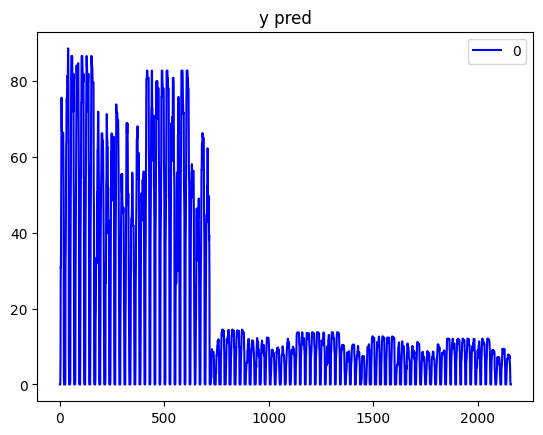

In [16]:
if local_test:
    print(f'Total: MAE: {mean_absolute_error(preds, y_test)}')
    print(f'Total: MAE on ReLU of y_pred: {mean_absolute_error(ReLU(preds), y_test)}')
    print(f'Total: MAE on abs(-) of y_pred: {mean_absolute_error(np.abs(preds), y_test)}')
    if y_scale:
        print(f'A: MAE: {mean_absolute_error(pred_a, y_test_a)}')
        print(f'B: MAE: {mean_absolute_error(pred_b, y_test_b)}')
        print(f'C: MAE: {mean_absolute_error(pred_c, y_test_c)}')

preds_df = pd.DataFrame(preds)

if local_test:
    fig, axs = plt.subplots(2,1,figsize = (15,15), sharex = True, sharey=True)
    y_test.plot(ax=axs[0], title='y test', color='red')
    preds_df.plot(ax=axs[1], title='y pred', color='blue')
else:
    preds_df.plot(title='y pred', color='blue')


In [47]:

# if save:
#     model.save_model("models/" + model_name)
#     pred_to_delivery(ReLU(preds),'Delivered_preds/' + model_name + '.csv')